# New Home Costs in Large Florida Counties

In this Wolfram Language notebook I explore how the price and availability of new homes has changed in ** large Florida counties from 2010 to 2019.  The data was collected from a bounty run by Dolt and freely available on DoltHub (https://www.dolthub.com).

From a local clone of this database, I extract the data in CSV format via dolt's command-line interface.  Because the database is large (>100GB), this command takes a few minutes to run, so I compress and write the results to storage.

The SQL finds all real estate transfers in Florida in which the year the building was built is after 2009 but before 2020.  Because the first owners may have sold the property I look for the first recorded sale.

In [ ]:
Import["!dolt sql -r csv -q \"
    SELECT a.* 
    FROM sales a 
    INNER JOIN (SELECT property_id, state, property_zip5, property_county, MIN(sale_datetime) AS first_sale_datetime 
                FROM sales 
                WHERE state = \\\"FL\\\" 
                GROUP BY property_id) b 
    ON a.property_id = b.property_id AND a.sale_datetime = b.first_sale_datetime 
    WHERE a.building_year_built > 2009 AND a.building_year_built < 2020 AND a.state = \\\"FL\\\";\" \
    | gzip > dataFL2.csv.gz"];

The following is a function that creates a density histogram that will be used to visualize the number of properties purchased as a function of both year and price.

In [1]:
densityHistogram[county_] := 
 DensityHistogram[{#[[9]]/1000, #[[13]]} & /@ 
   groupedByCounty[county], {{10}, {1}}, 
  PlotRange -> {{0, 1000}, Automatic, Automatic}, ImageSize -> 1000, 
  GridLines -> {Range[0, 1000, 25], Range[2010, 2020]}, 
  FrameTicks -> {Range[0, 1000, 100], Range[2010, 2020]},
  FrameTicksStyle -> Directive[Bold, 16], 
  FrameLabel -> {Style["Price ($1000)", Bold, 24], Style["Year", Bold, 24]}]

The following lines of code:
- import the data into the notebook
- extract the 7th (sell date) and 13th (build date) columns
- drop elements in which the build date is missing
- extract the year from the date string and convert it to a number (and drop the header)
- select rows in which the first sell date and the build date are within one year of each other and drop all sales under $10,000 (which are likely estate transfers)
- report that there are about 79,000 remaining records

In [2]:
data = Import["dataFL2.csv.gz"];
dates = data[[All, {7, 13}]];
dates = Select[dates, #[[2]] != "" &];
data = MapAt[ToExpression[StringSplit[#, "-"][[1]]] &, data, {All, 7}][[2 ;;]];
data = Select[data, Abs[#[[7]] - #[[13]]] <= 1 && #[[9]] > 10000 &];
Length[data]

79266

The distribution of the prices of homes sold in this data then looks like the following. Note that the majority of the new homes sold were in the range &225k to &300k. There is a long tail of houses sold for over &500k and only those up to &1M are shown here.

-Graphics-
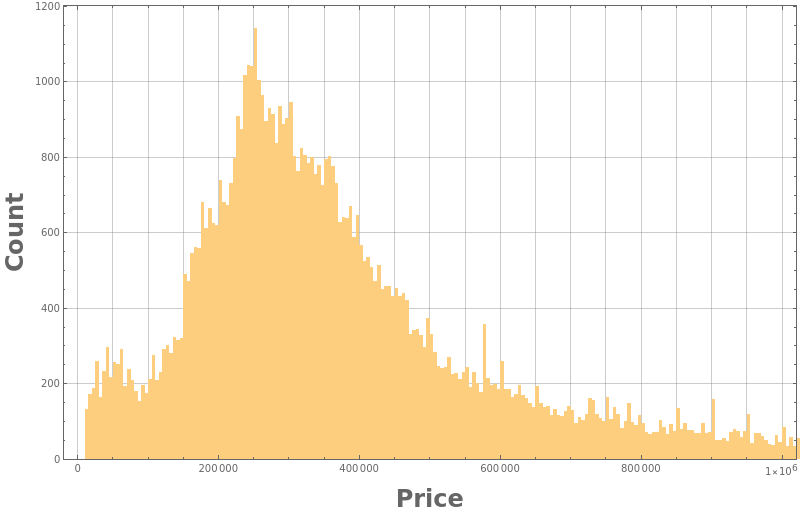

In [33]:
Histogram[data[[All, 9]], {5000}, PlotRange -> {{0, 1000000}, Automatic}, 
    ImageSize->800, 
    GridLines->{Range[0,1000000,50000],Automatic},
    Frame->True,FrameLabel -> {Style["Price", Bold, 24], Style["Count", Bold, 24]}]

To better view the long tail of prices, I plot the same information used in the truncated histogram above but with a logarithmic scale of prices.  The range now extends to &20M, and, while the bin groups are slightly different, it's still clear that the majority of homes sold for around &300k.  However, it's now clear that a significant number of homes sold for more than &1M with many going for over &10M.

-Graphics-
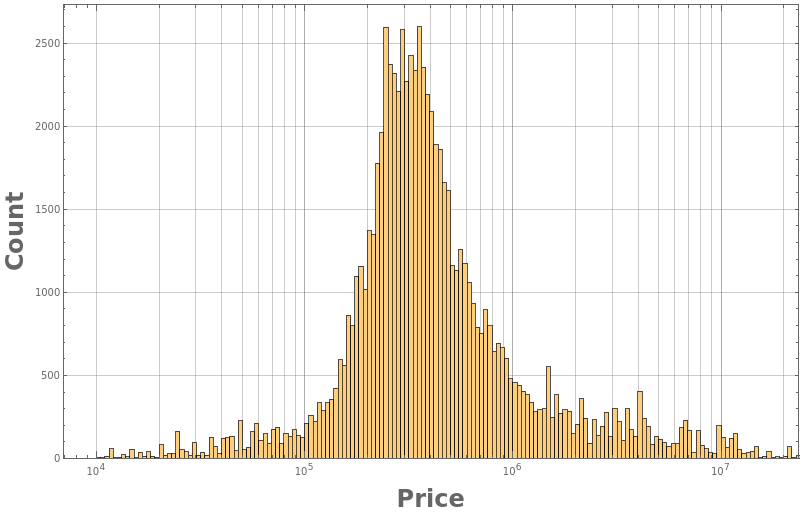

In [32]:
Histogram[data[[All, 9]], {"Log", 250}, PlotRange -> {{0, 20000000}, Automatic}, 
    ImageSize->800, 
    GridLines->{Sort[Flatten[Outer[Times,Range[0,1,0.1],10^{5,6,7,8}]]],Automatic},
    Frame->True,FrameLabel -> {Style["Price", Bold, 24], Style["Count", Bold, 24]}]

Let's explore the individual counties and how prices changed over time.

# Counties

I explore the five largest counties in Florida for which data was collected.  They are:
 - Lee County, Red
 - Miami-Dade County, Green
 - Manatee County, Blue
 - Palm Beach County, Orange
 - Lake County, Yellow
 - Hillsborough County, Purple

The map below shows the location of these counties.

GeoGraphics[-Graphics-, GeoBackground -> 
 
>    {GeoStyling[StreetMapNoLabels], GeoStyling[VectorLabels]}, 
 
>   GeoCenter -> GeoPosition[{27.7731, -83.8329}], GeoGridLines -> None, 
 
>   GeoGridLinesStyle -> GrayLevel[0.4, 0.3], 
 
>   GeoGridRange -> {{-88.0151, -79.6508}, {24.9784, 33.0115}}, 
 
>   GeoGridRangePadding -> None, GeoModel -> ITRF00, GeoProjection -> Mercator, 
 
>   GeoRange -> {{24.2228, 31.3234}, {-88.0151, -79.6508}}, GeoRangePadding -> Full, 
 
>   GeoResolution -> Automatic, GeoServer -> {Automatic}, GeoZoomLevel -> 8, 
 
>   MetaInformation -> 
 
>    <|GeoMetaInformation -> 
 
>      <|Attribution -> 
 
>        Hyperlink[Wolfram Knowledgebase, https://www.wolfram.com/], 
 
>         Hyperlink[© MapTiler, https://www.maptiler.com/copyright/], 
 
>         Hyperlink[© OpenStreetMap contributors, 
 
>          https://www.openstreetmap.org/copyright], AttributionType -> Tooltip, 
 
>       GeoModel -> ITRF00, LonLatBox -> {{-88.0151, -79.6508}, {24.2228, 31.3234}}, 
 
>       PlotRange -> {{-88.017, -79.6454}, {24.9774, 33.0139}}, Projection -> Mercator, 
 
>       Software -> Created with the Wolfram Language: www.wolfram.com, 
 
>       TileSources -> {Wolfram, OSM, MapTiler}|>|>]
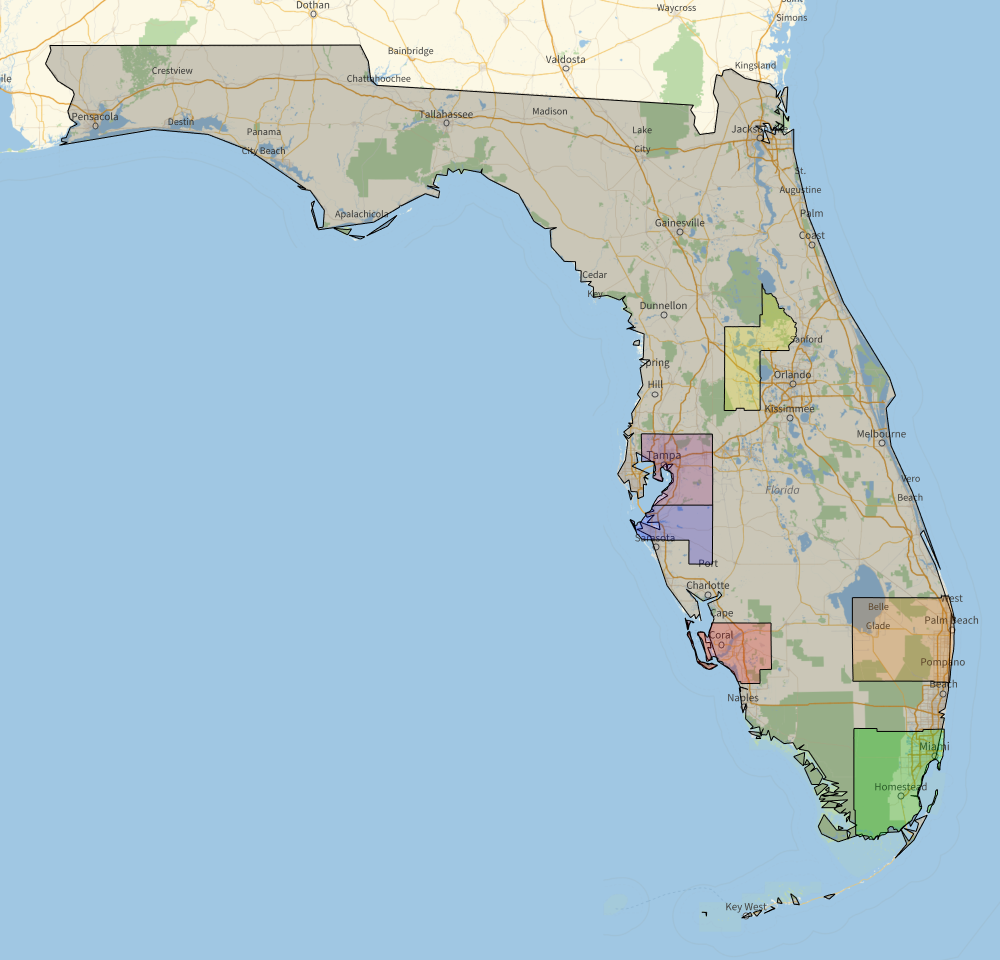

In [217]:
GeoGraphics[{EdgeForm[Black], 
  Polygon[Entity["AdministrativeDivision", {"Florida", "UnitedStates"}]], 
  Red, Polygon[Entity["AdministrativeDivision", {"LeeCounty", "Florida", "UnitedStates"}]], 
  Green, Polygon[Entity["AdministrativeDivision", {"MiamiDadeCounty", "Florida", "UnitedStates"}]], 
  Blue, Polygon[Entity["AdministrativeDivision", {"ManateeCounty", "Florida", "UnitedStates"}]], 
  Orange, Polygon[Entity["AdministrativeDivision", {"PalmBeachCounty", "Florida", "UnitedStates"}]], 
  Yellow, Polygon[Entity["AdministrativeDivision", {"LakeCounty", "Florida", "UnitedStates"}]], 
  Purple, Polygon[Entity["AdministrativeDivision", {"HillsboroughCounty", "Florida", "UnitedStates"}]]}, 
   ImageSize -> 1000]

I group the data by counties--the fifth column of data and create an empty association (dictionary) to collect statistical values for each county.

In [8]:
groupedByCounty = GroupBy[data, #[[5]] &];

In [9]:
medianPrice = <||>;

## Miami-Dade

In [10]:
ii = 2;
county = Keys[groupedByCounty][[ii]]
num = Length[groupedByCounty[[ii]]];
median = Median[groupedByCounty[[ii, All, 9]]] // N;
mean = Mean[groupedByCounty[[ii, All, 9]]] // N;
TeXForm[medianPrice[county] = {num, median, mean}]

MIAMI-DADE
\{27719,423000.,1.03598\times 10^6\}

For the period of interest, there were about 28,000 new homes sold in Miami-Dade county.  The median price of these homes is &423,000 and the mean--skewed by very expensive homes--is over one million dollars. The details are shown in the histogram below and note that the long tail of expensive homes is what makes the mean so much larger than the median.

-Graphics-
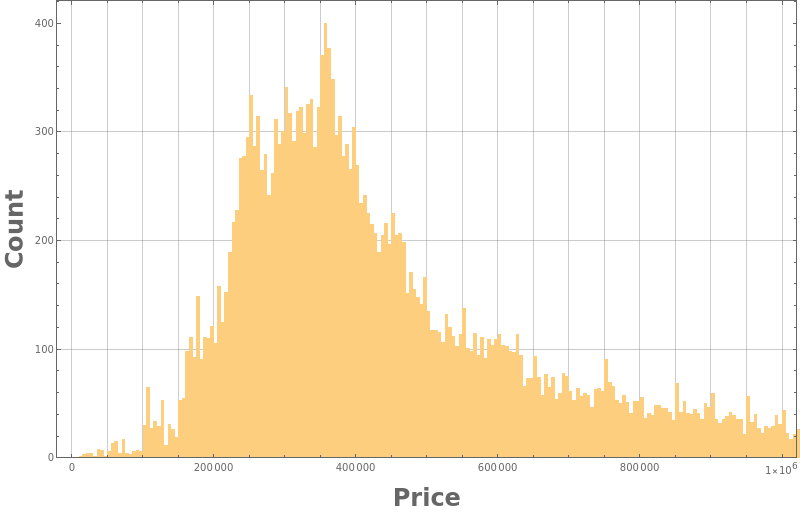

In [16]:
Histogram[groupedByCounty[county][[All, 9]], {5000}, PlotRange -> {{0, 1000000}, Automatic}, 
    ImageSize->800, 
    GridLines->{Range[0,1000000,50000],Automatic},
    Frame->True,FrameLabel -> {Style["Price", Bold, 24], Style["Count", Bold, 24]}]

To understand how this is changing over time, the 3-D histogram below shows the number of new homes sold each year in &10,000-price-range increments.

-Graphics3D-
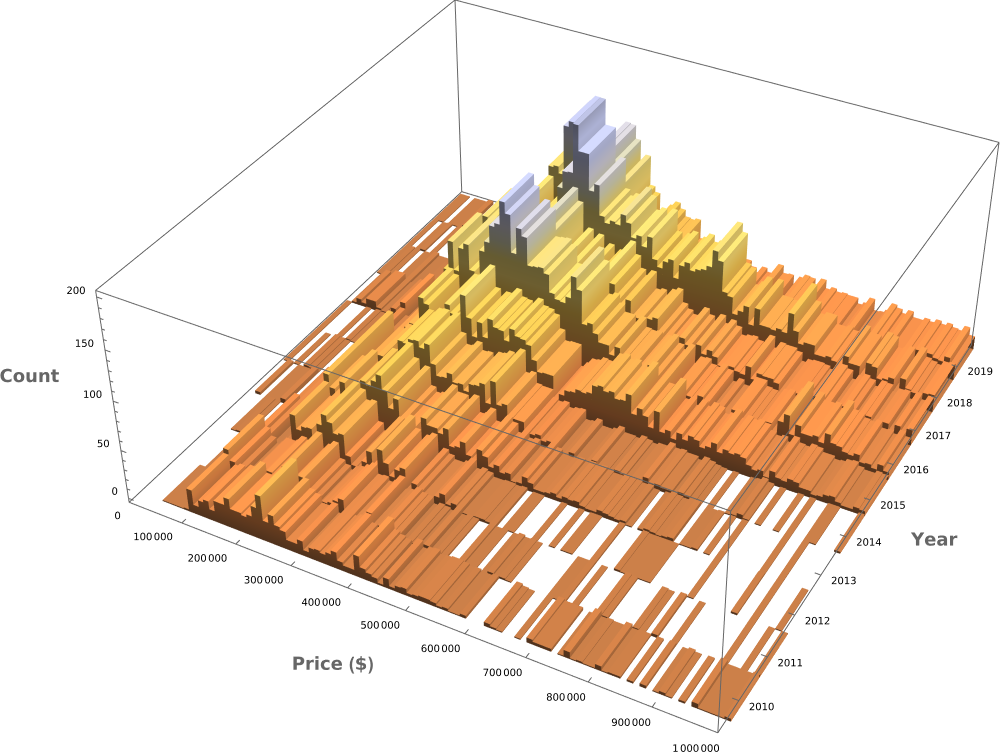

In [17]:
Histogram3D[
 groupedByCounty[county][[All, {9, 13}]], {{10000}, {1}}, 
 PlotRange -> {{0, 1000000}, Automatic, Automatic}, 
 Ticks->{Range[0,10^6,10^5],Range[2010,2020],Automatic},
 ChartElementFunction -> "GradientScaleCube", ImageSize -> 1000, 
 AxesLabel->((Style[#,18,Bold]&)/@{"Price ($)","Year","Count"})]

This makes it clear that while the number of new homes going on the market in Miami-Dade county has increased significantly form 2010 to 2019, the prices have also increased.  A different (top-down) perspective on this data is shown in the "density" histogram below.  It's clear that 2018 saw a lot of new homes sold, but the prices shifted significantly higher.  The general trend of prices increasing year-over-year is also very clear in the density histogram.

-Graphics-
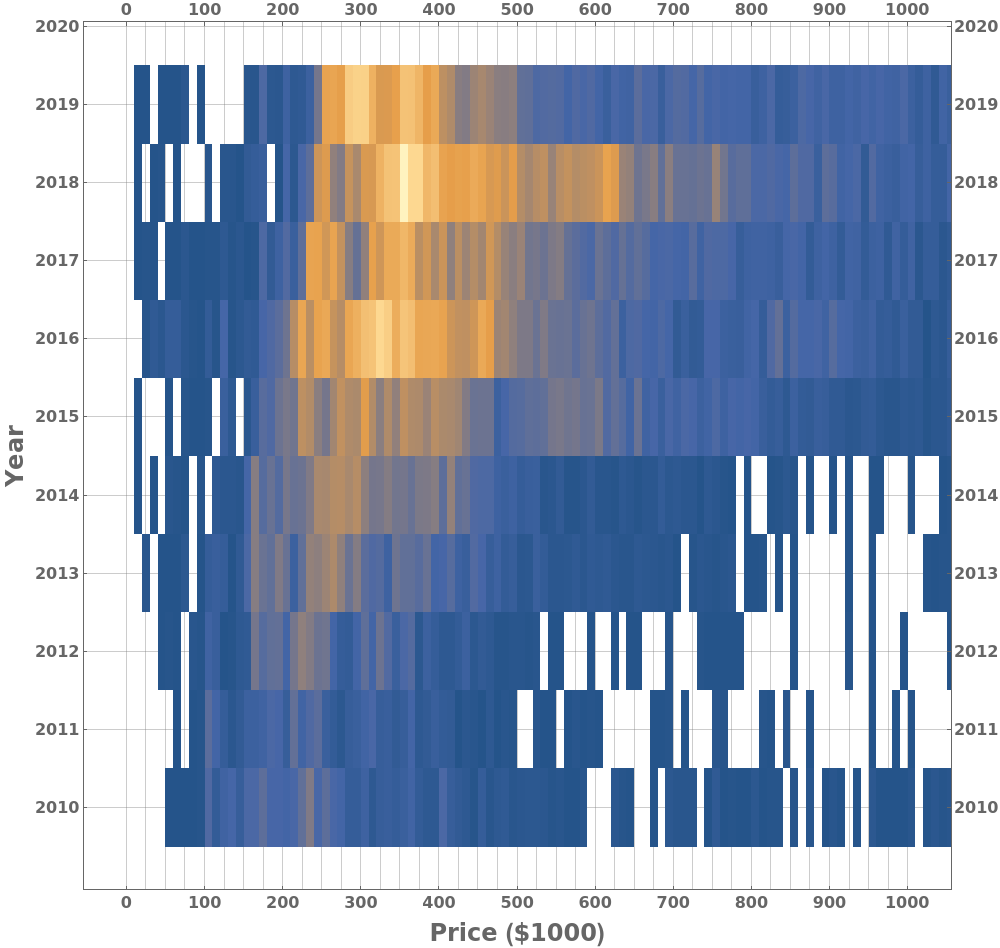

In [18]:
densityHistogram[county]

From the previous two charts, it's clear that the median new home price changes substantially each year.  Thus, I group the county data by year, find median price each year, and create a bar chart showing the data.

<|2010 -> 270000., 2011 -> 300744., 2012 -> 255293., 2013 -> 298718., 2014 -> 332000., 
 
>   2015 -> 453500., 2016 -> 416900., 2017 -> 459900., 2018 -> 520000., 2019 -> 450000.|>
-Graphics-
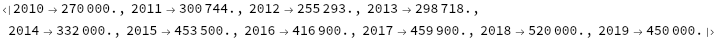
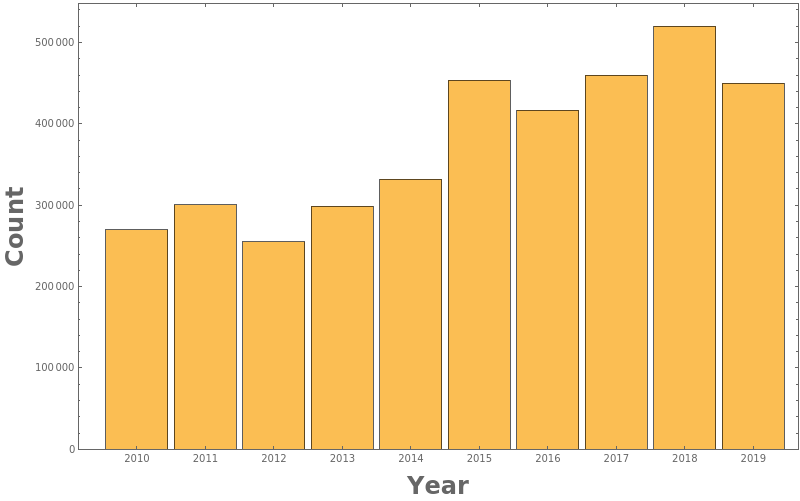

In [19]:
groupedByYear = GroupBy[groupedByCounty[county], #[[13]] &];
medianByYear = KeySort[Median[#[[All, 9]]] & /@ groupedByYear // N]
BarChart[medianByYear, 
    ChartLabels -> Keys[medianByYear], 
    ImageSize->800, 
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Median Price ($)"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

While the trend isn't monotonic, there is a definite trend towards higher new home prices from about &275,000 in the early 2010's to over &500,000 in 2018.  Prices appear to have jumped significantly from 2014 (&332,000) to 2015 (&453,500).  Prices did, however, decline from 2018 to 2019.  Unfortunately, as shown in the chart below, there were significantly fewer new homes sold in 2019 than in 2018.

-Graphics-
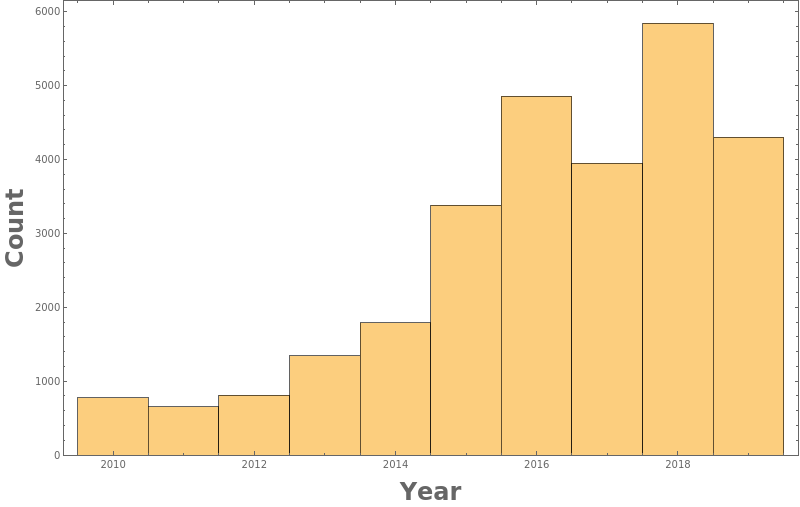

In [22]:
Histogram[groupedByCounty[county][[All, 13]],
    ImageSize->800,
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Count"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

## Manatee

In [23]:
ii = 3;
county = Keys[groupedByCounty][[ii]]
num = Length[groupedByCounty[[ii]]];
median = Median[groupedByCounty[[ii, All, 9]]] // N;
mean = Mean[groupedByCounty[[ii, All, 9]]] // N;
TeXForm[medianPrice[county] = {num, median, mean}]

MANATEE
\{8341,250000.,469576.\}

To do

-Graphics-
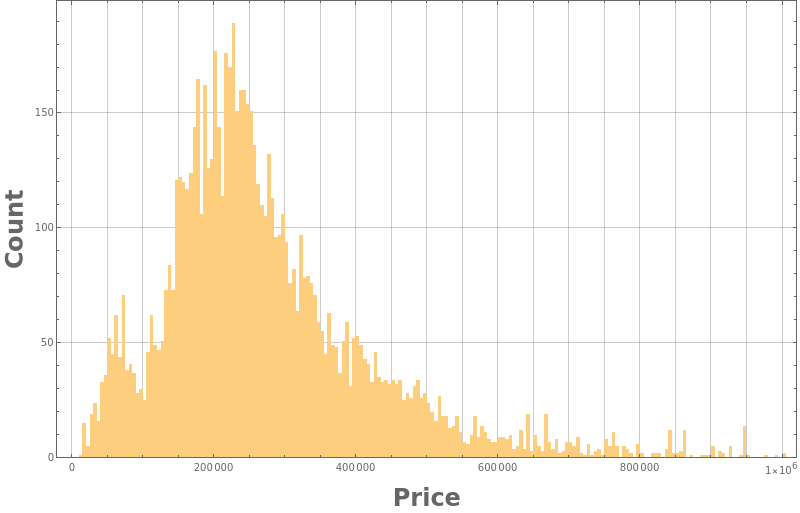

In [29]:
Histogram[groupedByCounty[county][[All, 9]], {5000}, PlotRange -> {{0, 1000000}, Automatic}, 
    ImageSize->800, 
    GridLines->{Range[0,1000000,50000],Automatic},
    Frame->True,FrameLabel -> {Style["Price", Bold, 24], Style["Count", Bold, 24]}]

To do

-Graphics3D-
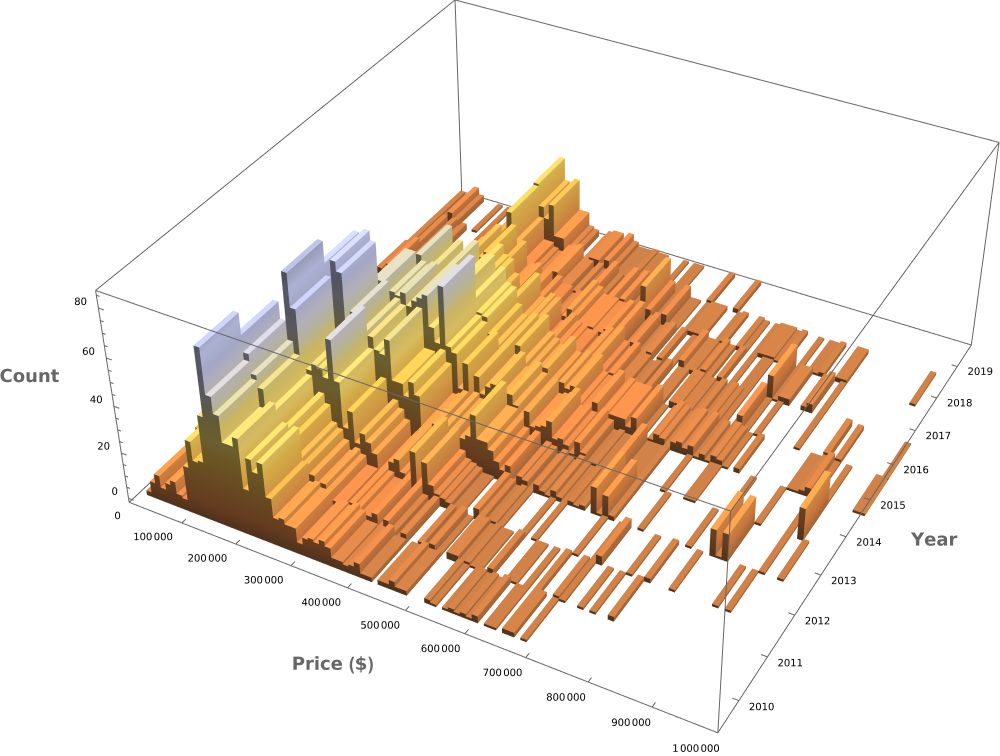

In [30]:
Histogram3D[
 groupedByCounty[county][[All, {9, 13}]], {{10000}, {1}}, 
 PlotRange -> {{0, 1000000}, Automatic, Automatic}, 
 Ticks->{Range[0,10^6,10^5],Range[2010,2020],Automatic},
 ChartElementFunction -> "GradientScaleCube", ImageSize -> 1000, 
 AxesLabel->((Style[#,18,Bold]&)/@{"Price ($)","Year","Count"})]

To do

-Graphics-
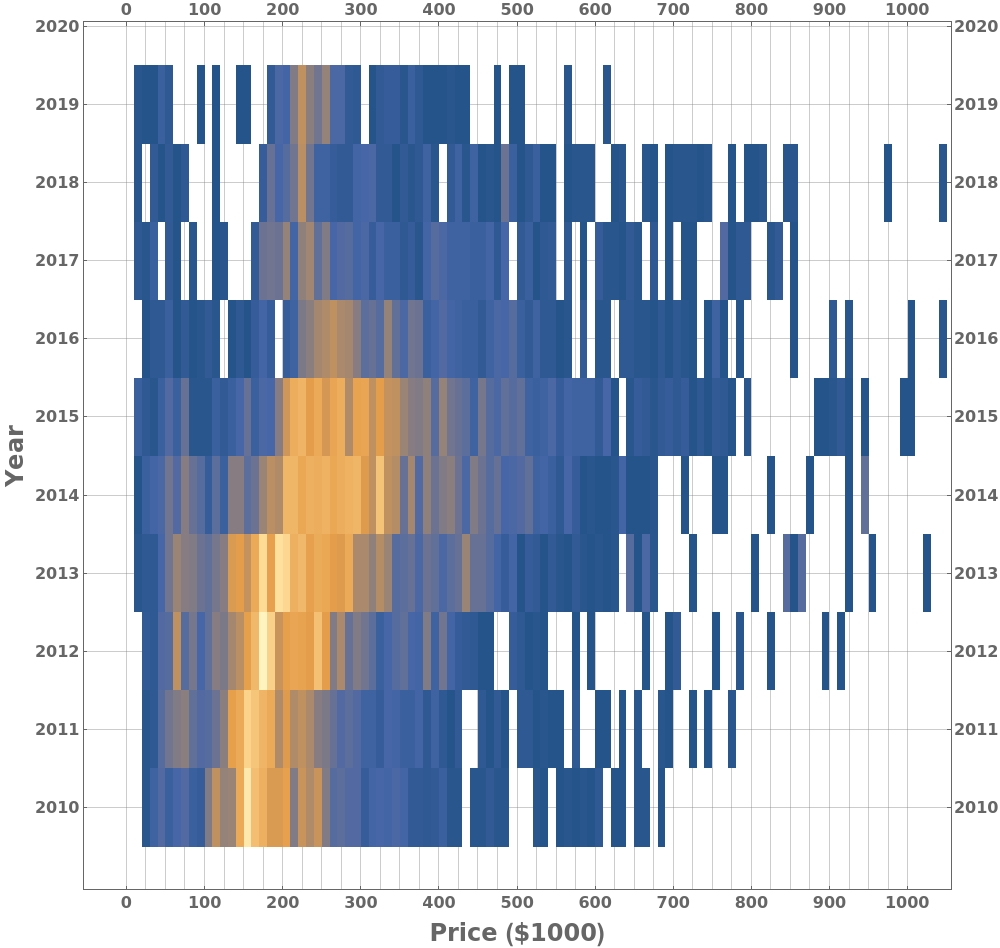

In [31]:
densityHistogram[county]

<|2010 -> 192100., 2011 -> 177900., 2012 -> 212250., 2013 -> 240400., 2014 -> 288200., 
 
>   2015 -> 309900., 2016 -> 314650., 2017 -> 301400., 2018 -> 292050., 2019 -> 240650.|>
-Graphics-
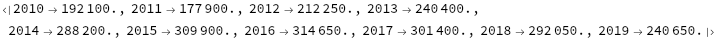
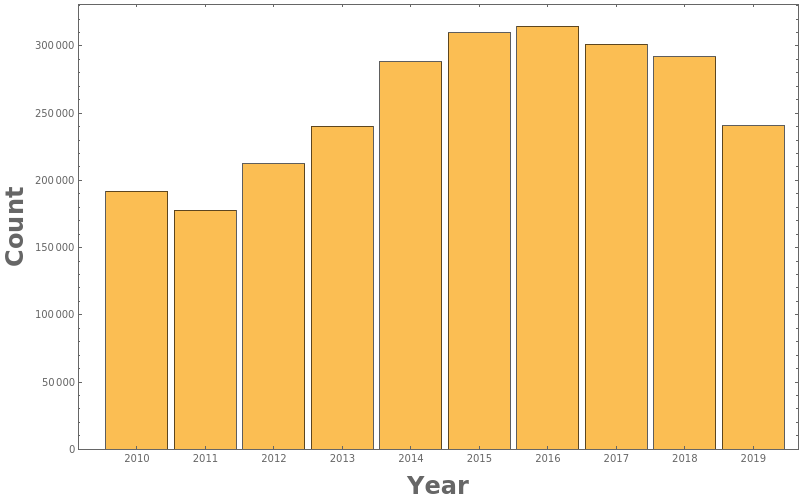

In [32]:
groupedByYear = GroupBy[groupedByCounty[county], #[[13]] &];
medianByYear = KeySort[Median[#[[All, 9]]] & /@ groupedByYear // N]
BarChart[medianByYear, 
    ChartLabels -> Keys[medianByYear], 
    ImageSize->800, 
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Median Price ($)"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

-Graphics-
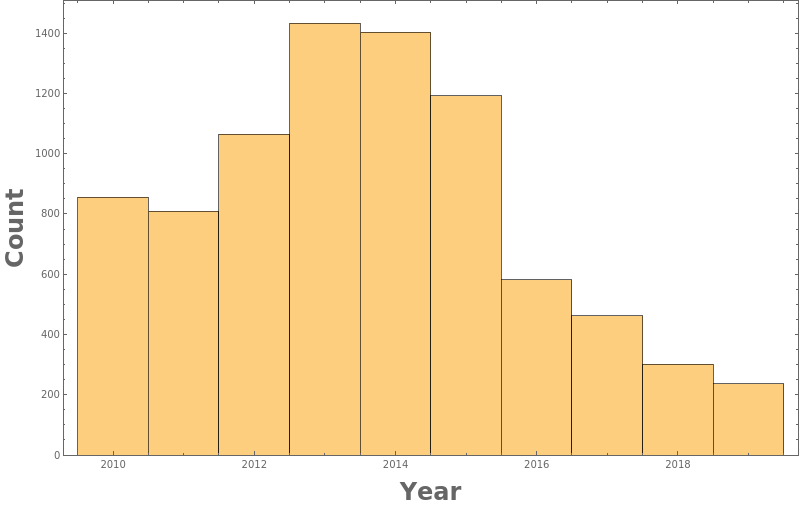

In [35]:
Histogram[groupedByCounty[county][[All, 13]],
    ImageSize->800,
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Count"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

## Palm Beach

In [36]:
ii = 4;
county = Keys[groupedByCounty][[ii]]
num = Length[groupedByCounty[[ii]]];
median = Median[groupedByCounty[[ii, All, 9]]] // N;
mean = Mean[groupedByCounty[[ii, All, 9]]] // N;
TeXForm[medianPrice[county] = {num, median, mean}]

PALM BEACH
\{7573,476790.,1.70818\times 10^6\}

To do

-Graphics-
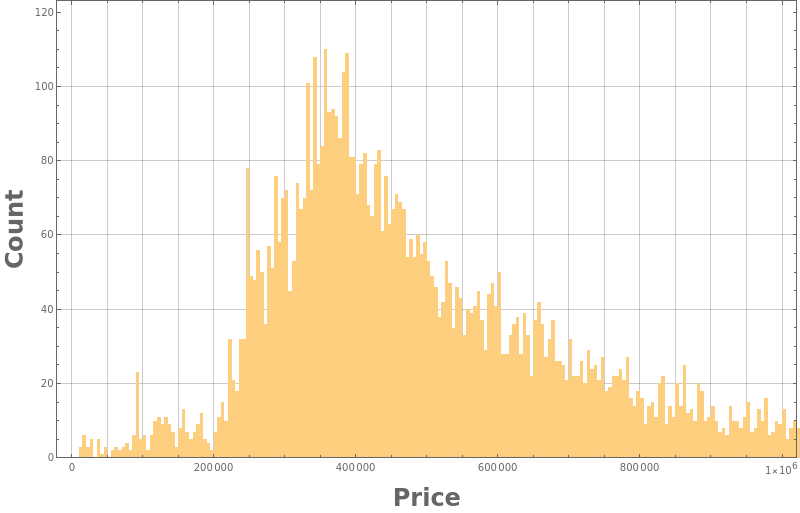

In [42]:
Histogram[groupedByCounty[county][[All, 9]], {5000}, PlotRange -> {{0, 1000000}, Automatic}, 
    ImageSize->800, 
    GridLines->{Range[0,1000000,50000],Automatic},
    Frame->True,FrameLabel -> {Style["Price", Bold, 24], Style["Count", Bold, 24]}]

To do

-Graphics3D-
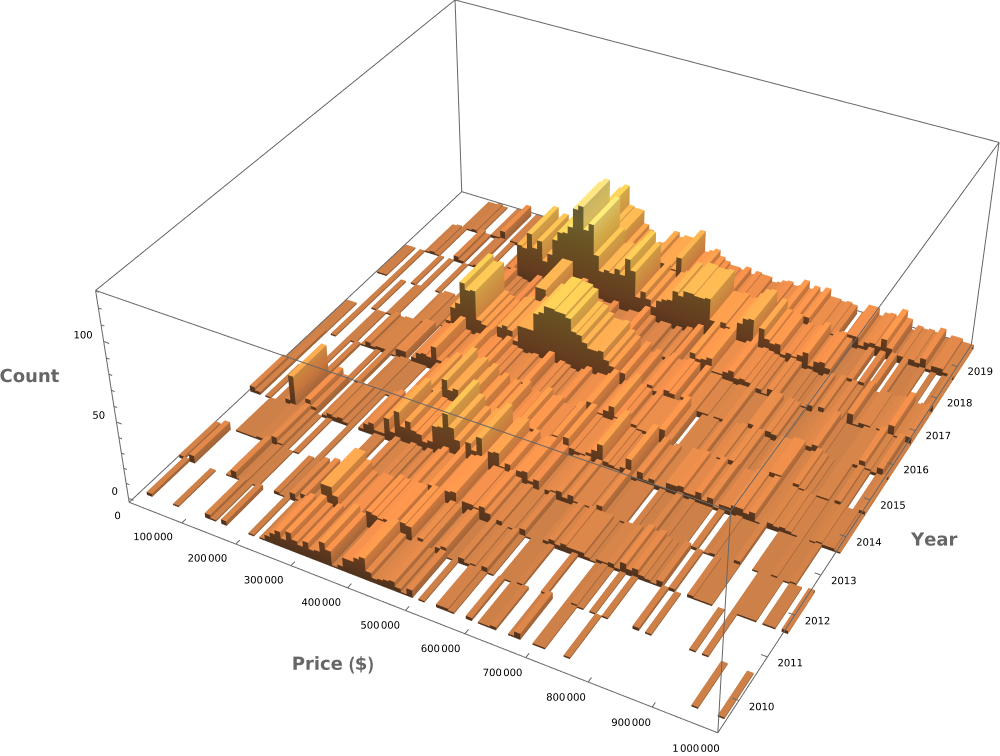

In [43]:
Histogram3D[
 groupedByCounty[county][[All, {9, 13}]], {{10000}, {1}}, 
 PlotRange -> {{0, 1000000}, Automatic, Automatic}, 
 Ticks->{Range[0,10^6,10^5],Range[2010,2020],Automatic},
 ChartElementFunction -> "GradientScaleCube", ImageSize -> 1000, 
 AxesLabel->((Style[#,18,Bold]&)/@{"Price ($)","Year","Count"})]

To do

-Graphics-
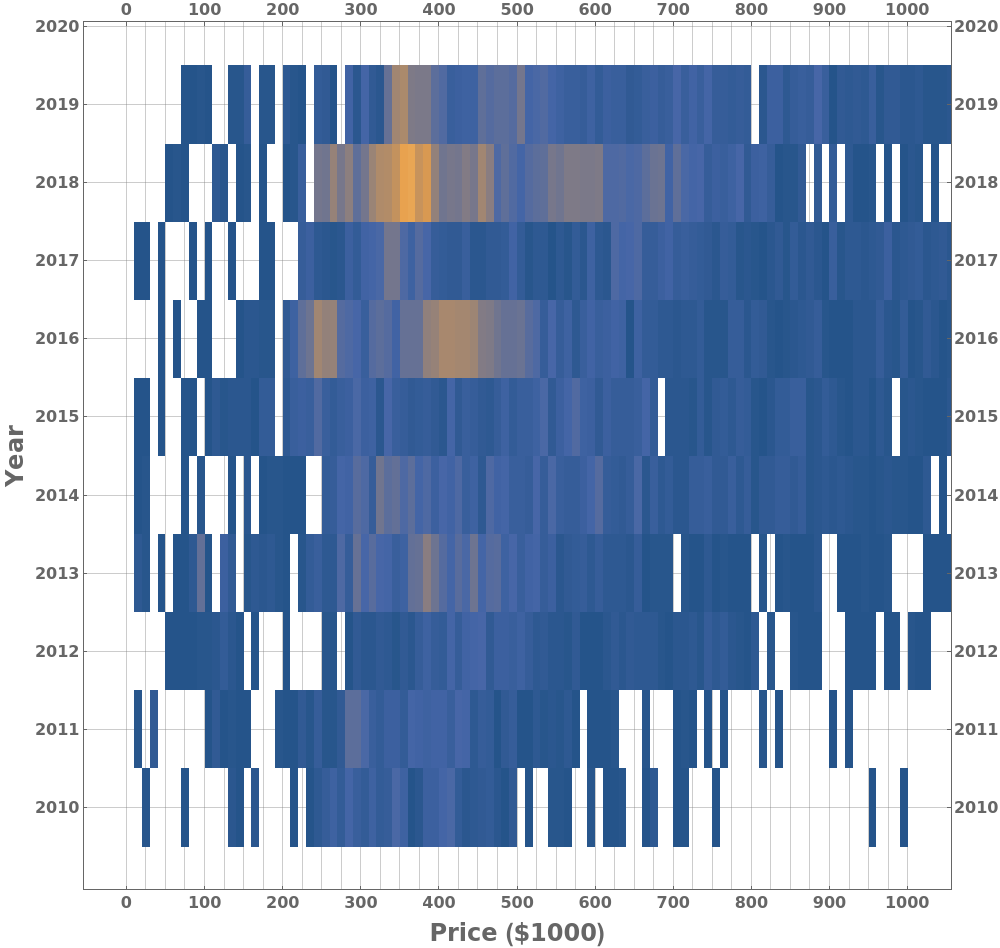

In [44]:
densityHistogram[county]

<|2010 -> 374784., 2011 -> 377277., 2012 -> 487982., 2013 -> 411193., 2014 -> 574453., 
 
>   2015 -> 570823., 2016 -> 439000., 2017 -> 645516., 2018 -> 452140., 2019 -> 605718.|>
-Graphics-
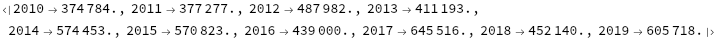
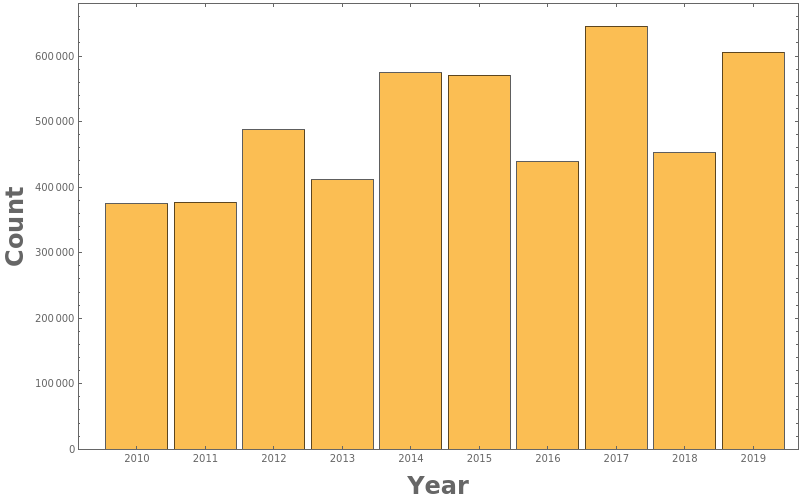

In [45]:
groupedByYear = GroupBy[groupedByCounty[county], #[[13]] &];
medianByYear = KeySort[Median[#[[All, 9]]] & /@ groupedByYear // N]
BarChart[medianByYear, 
    ChartLabels -> Keys[medianByYear], 
    ImageSize->800, 
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Median Price ($)"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

-Graphics-
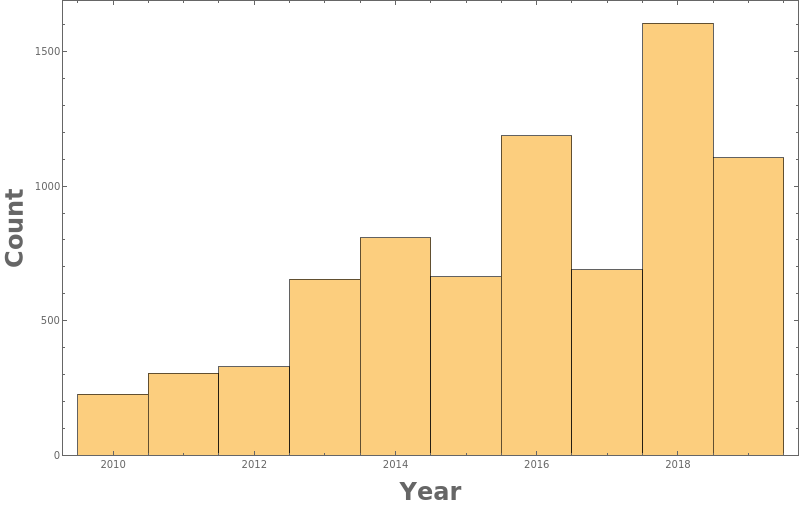

In [48]:
Histogram[groupedByCounty[county][[All, 13]],
    ImageSize->800,
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Count"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

## Lake

In [55]:
ii = 6;
county = Keys[groupedByCounty][[ii]]
num = Length[groupedByCounty[[ii]]];
median = Median[groupedByCounty[[ii, All, 9]]] // N;
mean = Mean[groupedByCounty[[ii, All, 9]]] // N;
TeXForm[medianPrice[county] = {num, median, mean}]

LAKE COUNTY
\{11802,266300.,371457.\}

To do

-Graphics-
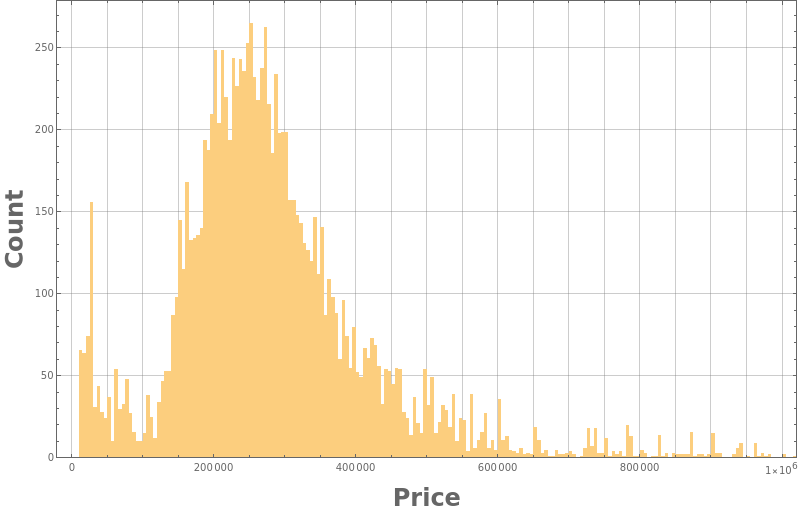

In [61]:
Histogram[groupedByCounty[county][[All, 9]], {5000}, PlotRange -> {{0, 1000000}, Automatic}, 
    ImageSize->800, 
    GridLines->{Range[0,1000000,50000],Automatic},
    Frame->True,FrameLabel -> {Style["Price", Bold, 24], Style["Count", Bold, 24]}]

To do

-Graphics3D-
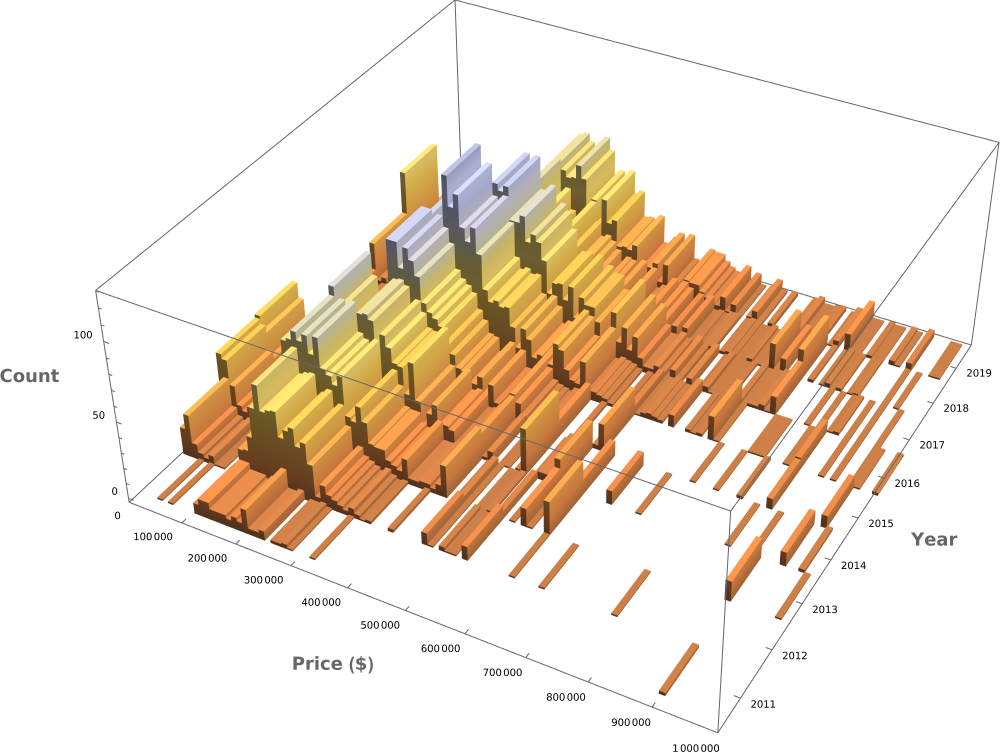

In [62]:
Histogram3D[
 groupedByCounty[county][[All, {9, 13}]], {{10000}, {1}}, 
 PlotRange -> {{0, 1000000}, Automatic, Automatic}, 
 Ticks->{Range[0,10^6,10^5],Range[2010,2020],Automatic},
 ChartElementFunction -> "GradientScaleCube", ImageSize -> 1000, 
 AxesLabel->((Style[#,18,Bold]&)/@{"Price ($)","Year","Count"})]

To do

-Graphics-
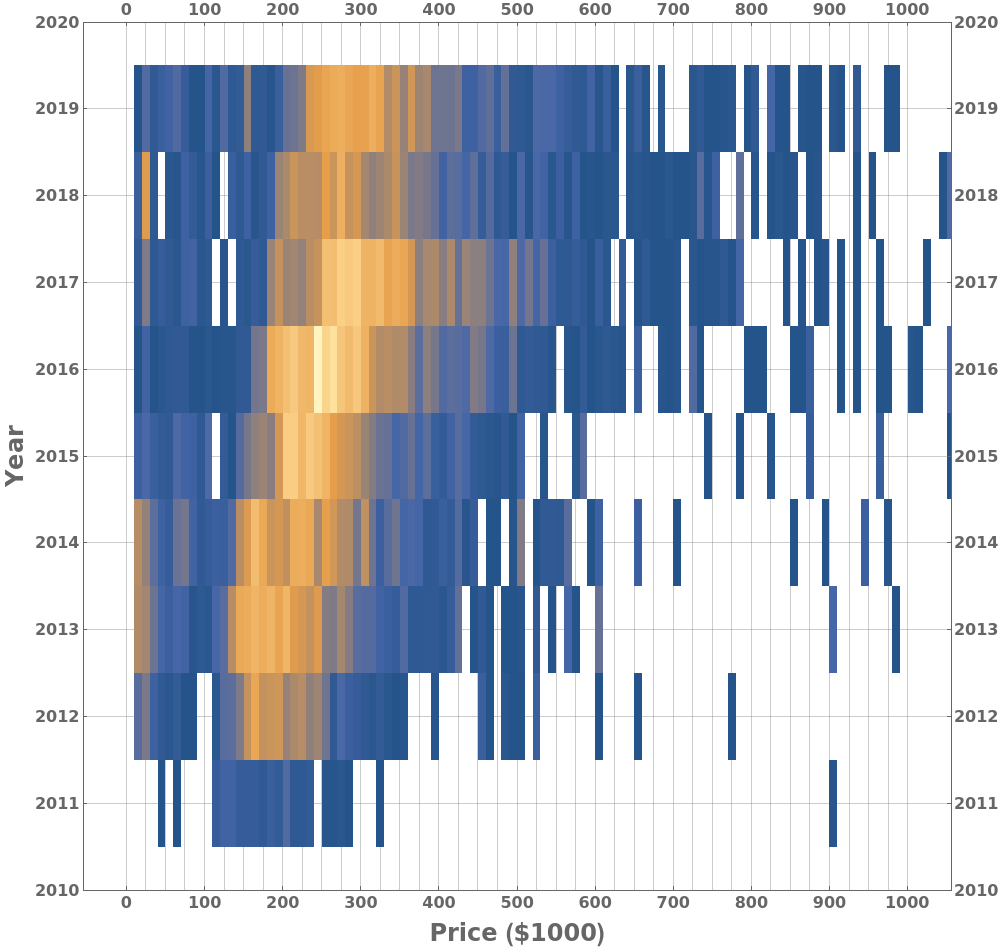

In [63]:
densityHistogram[county]

<|2011 -> 179000., 2012 -> 190950., 2013 -> 204000., 2014 -> 227150., 2015 -> 243600., 
 
>   2016 -> 273800., 2017 -> 315900., 2018 -> 295700., 2019 -> 319400.|>
-Graphics-
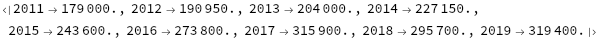
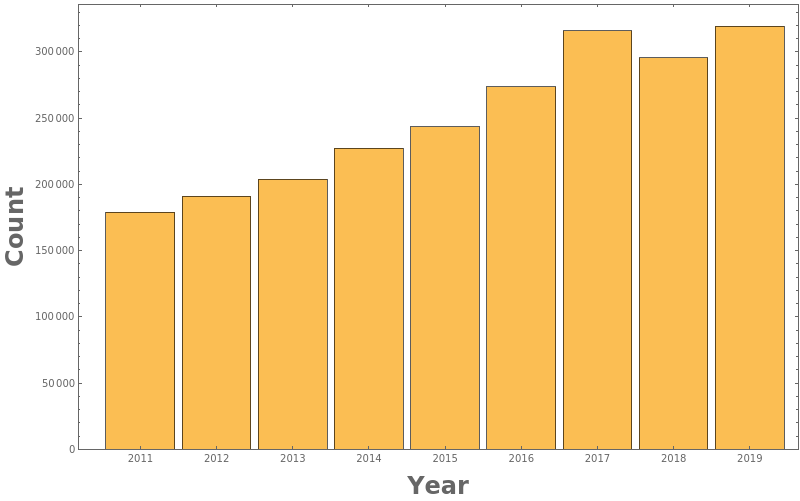

In [64]:
groupedByYear = GroupBy[groupedByCounty[county], #[[13]] &];
medianByYear = KeySort[Median[#[[All, 9]]] & /@ groupedByYear // N]
BarChart[medianByYear, 
    ChartLabels -> Keys[medianByYear], 
    ImageSize->800, 
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Median Price ($)"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

-Graphics-
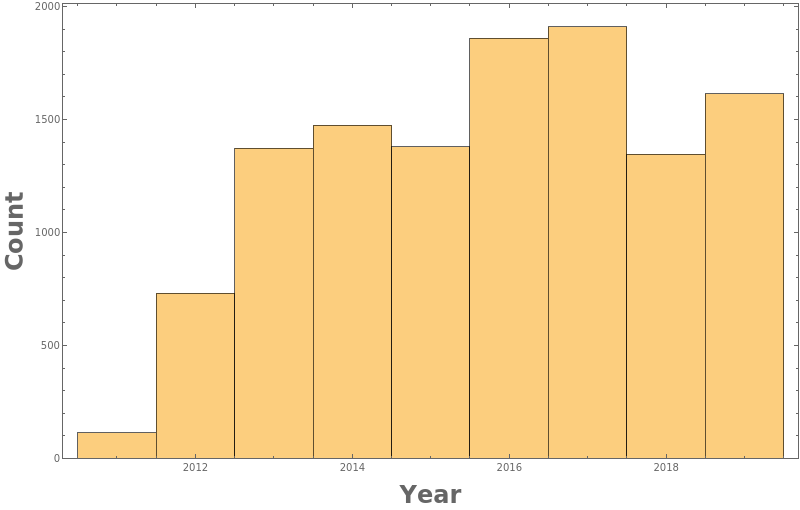

In [67]:
Histogram[groupedByCounty[county][[All, 13]],
    ImageSize->800,
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Count"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

## Lee

In [68]:
ii = 7;
county = Keys[groupedByCounty][[ii]]
num = Length[groupedByCounty[[ii]]];
median = Median[groupedByCounty[[ii, All, 9]]] // N;
mean = Mean[groupedByCounty[[ii, All, 9]]] // N;
TeXForm[medianPrice[county] = {num, median, mean}]

LEE
\{8621,335595.,881158.\}

To do

-Graphics-
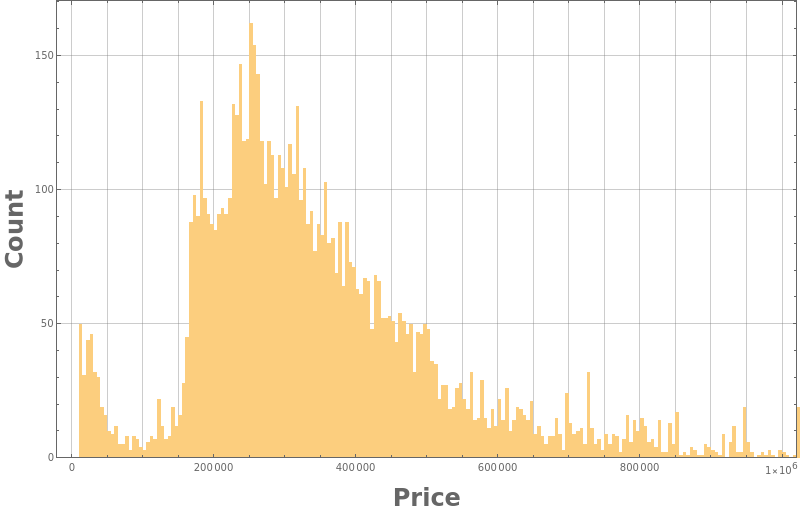

In [74]:
Histogram[groupedByCounty[county][[All, 9]], {5000}, PlotRange -> {{0, 1000000}, Automatic}, 
    ImageSize->800, 
    GridLines->{Range[0,1000000,50000],Automatic},
    Frame->True,FrameLabel -> {Style["Price", Bold, 24], Style["Count", Bold, 24]}]

To do

-Graphics3D-
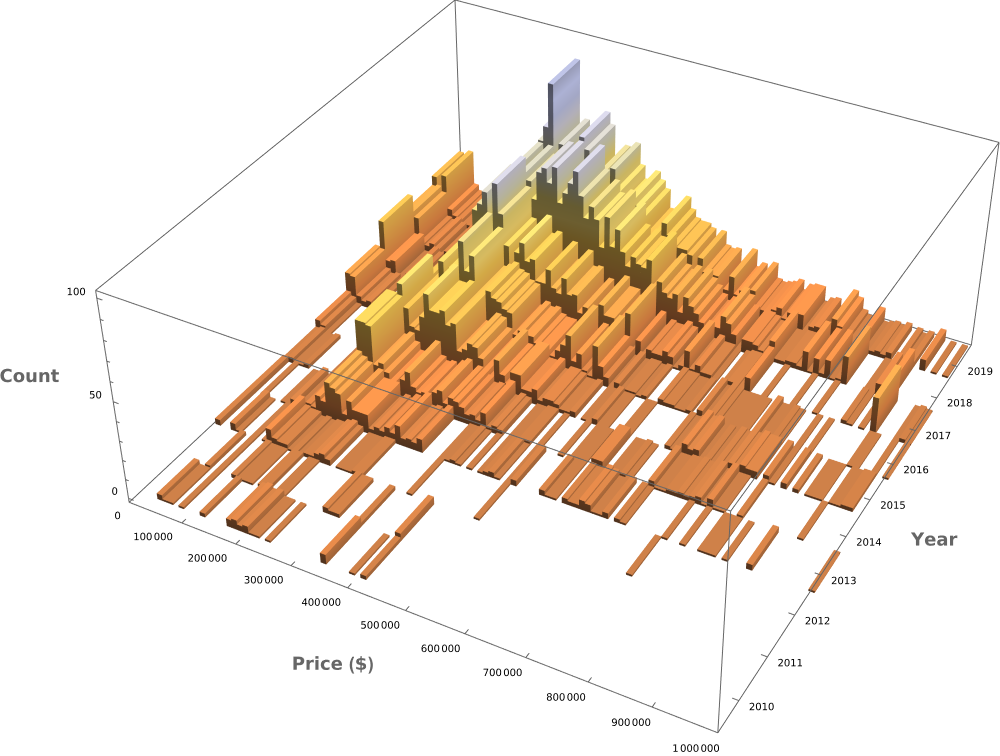

In [75]:
Histogram3D[
 groupedByCounty[county][[All, {9, 13}]], {{10000}, {1}}, 
 PlotRange -> {{0, 1000000}, Automatic, Automatic}, 
 Ticks->{Range[0,10^6,10^5],Range[2010,2020],Automatic},
 ChartElementFunction -> "GradientScaleCube", ImageSize -> 1000, 
 AxesLabel->((Style[#,18,Bold]&)/@{"Price ($)","Year","Count"})]

To do

-Graphics-
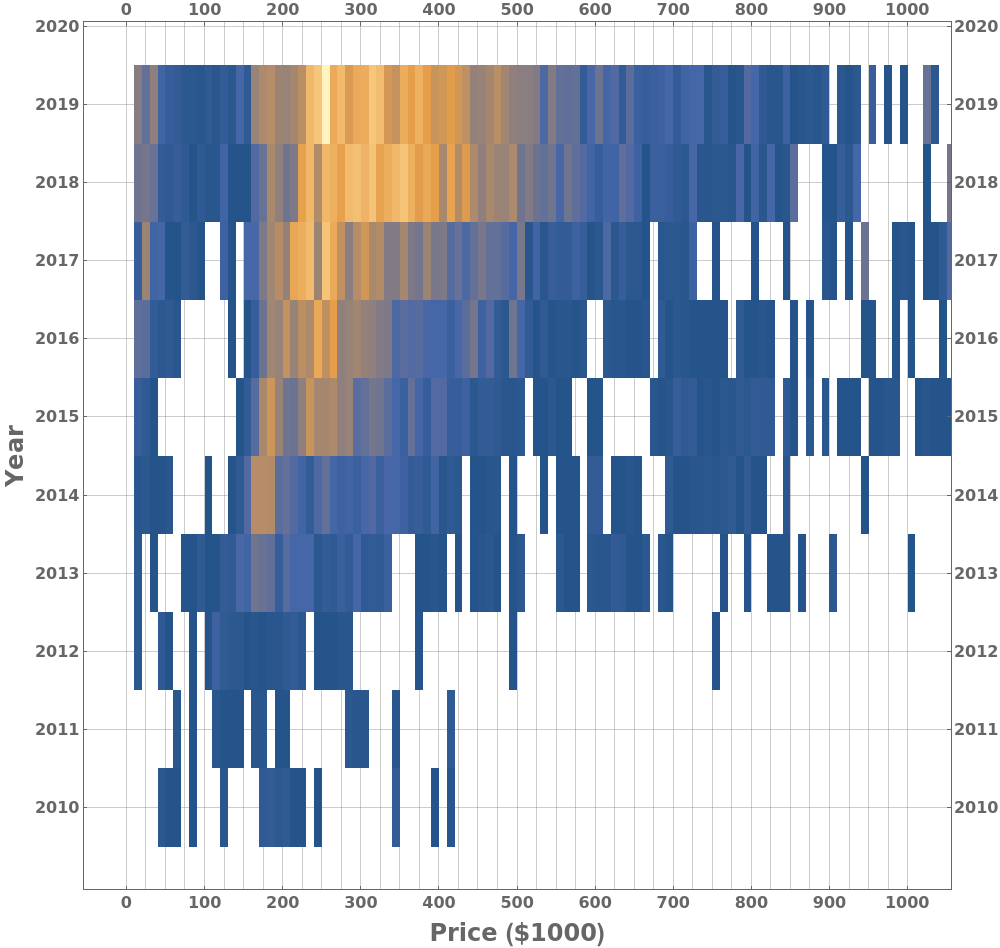

In [76]:
densityHistogram[county]

<|2010 -> 190000., 2011 -> 285000., 2012 -> 161950., 2013 -> 238750., 2014 -> 251135., 
 
>   2015 -> 279503., 2016 -> 288448., 2017 -> 321794., 2018 -> 380096., 2019 -> 377000.|>
-Graphics-
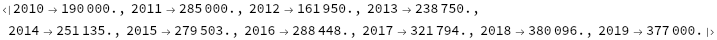
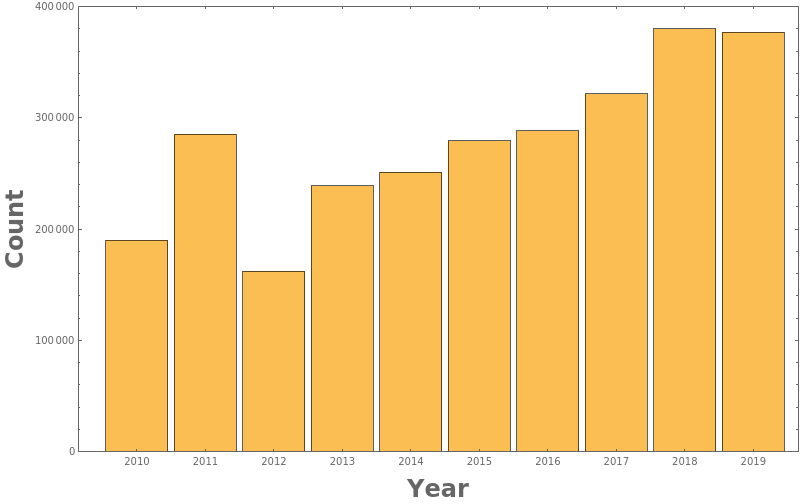

In [77]:
groupedByYear = GroupBy[groupedByCounty[county], #[[13]] &];
medianByYear = KeySort[Median[#[[All, 9]]] & /@ groupedByYear // N]
BarChart[medianByYear, 
    ChartLabels -> Keys[medianByYear], 
    ImageSize->800, 
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Median Price ($)"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

-Graphics-
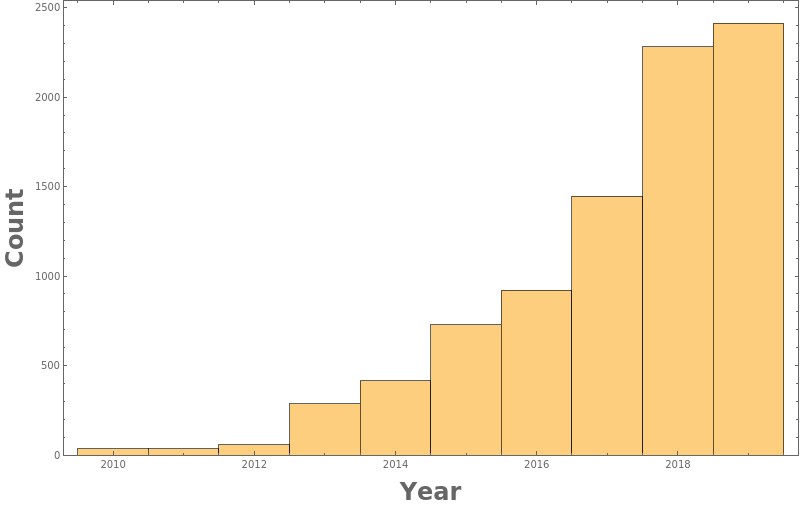

In [80]:
Histogram[groupedByCounty[county][[All, 13]],
    ImageSize->800,
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Count"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

## Hillsborough

In [81]:
ii = 1;
county = Keys[groupedByCounty][[ii]]
num = Length[groupedByCounty[[ii]]];
median = Median[groupedByCounty[[ii, All, 9]]] // N;
mean = Mean[groupedByCounty[[ii, All, 9]]] // N;
TeXForm[medianPrice[county] = {num, median, mean}]

HILLSBOROUGH COUNTY
\{5681,1.7\times 10^6,2.80128\times 10^6\}

To do

-Graphics-
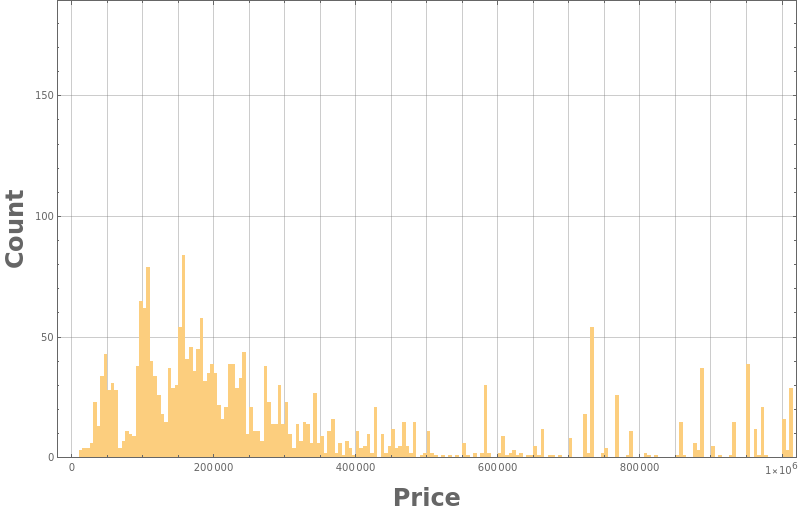

In [87]:
Histogram[groupedByCounty[county][[All, 9]], {5000}, PlotRange -> {{0, 1000000}, Automatic}, 
    ImageSize->800, 
    GridLines->{Range[0,1000000,50000],Automatic},
    Frame->True,FrameLabel -> {Style["Price", Bold, 24], Style["Count", Bold, 24]}]

To do

-Graphics3D-
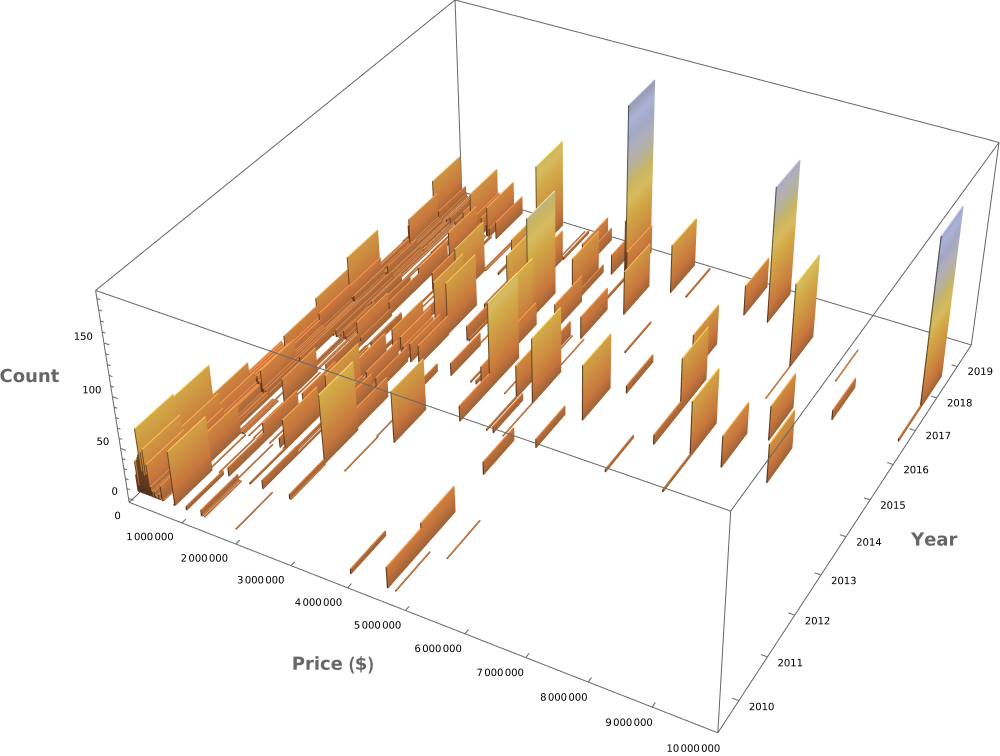

In [96]:
Histogram3D[
 groupedByCounty[county][[All, {9, 13}]], {{20000}, {1}}, 
 PlotRange -> {{0, 10000000}, Automatic, Automatic}, 
 Ticks->{Range[0,10^7,10^6],Range[2010,2020],Automatic},
 ChartElementFunction -> "GradientScaleCube", ImageSize -> 1000, 
 AxesLabel->((Style[#,18,Bold]&)/@{"Price ($)","Year","Count"})]

To do

-Graphics-
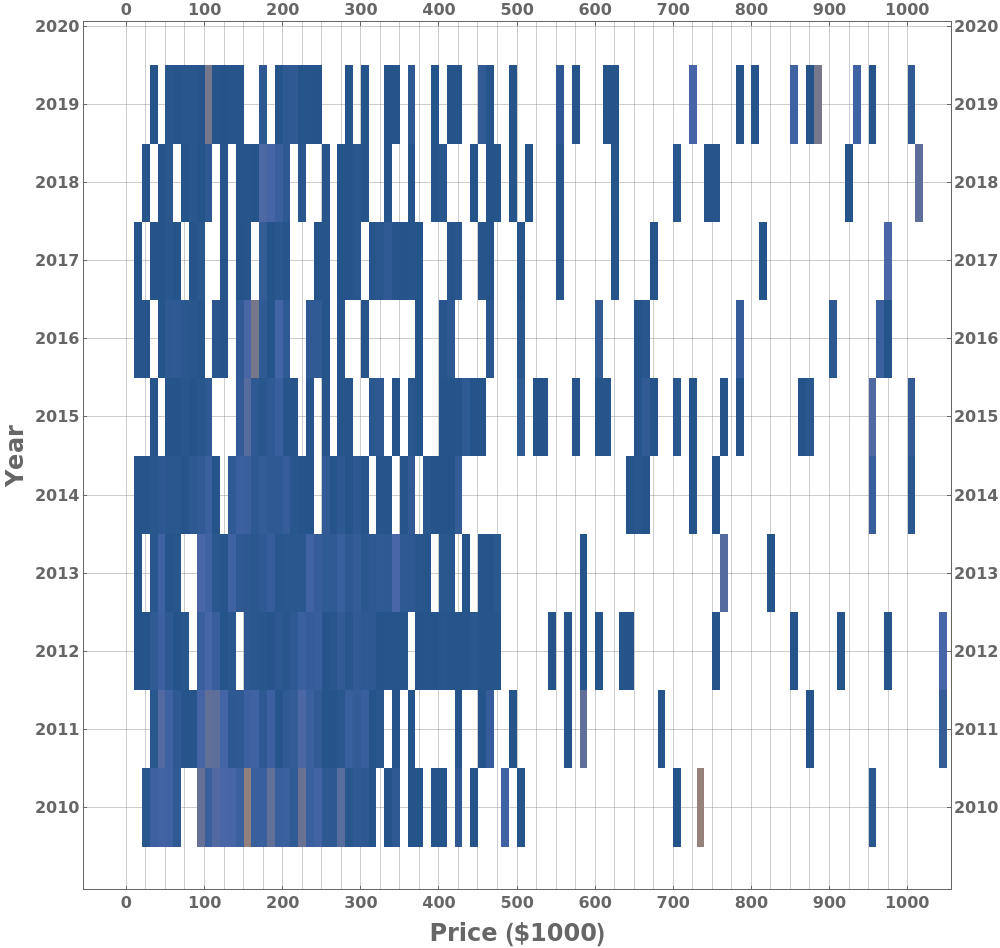

In [89]:
densityHistogram[county]

<|2010 -> 188000., 2011 -> 182000., 2012 -> 326900., 2013 -> 407950., 2014 -> 387700., 
 
                  6                 6                  6                  6
>   2015 -> 3.5 10 , 2016 -> 2.12 10 , 2017 -> 2.748 10 , 2018 -> 4.491 10 , 
 
                     6
>   2019 -> 4.0243 10 |>
-Graphics-
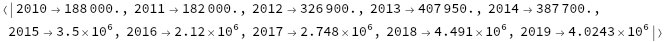
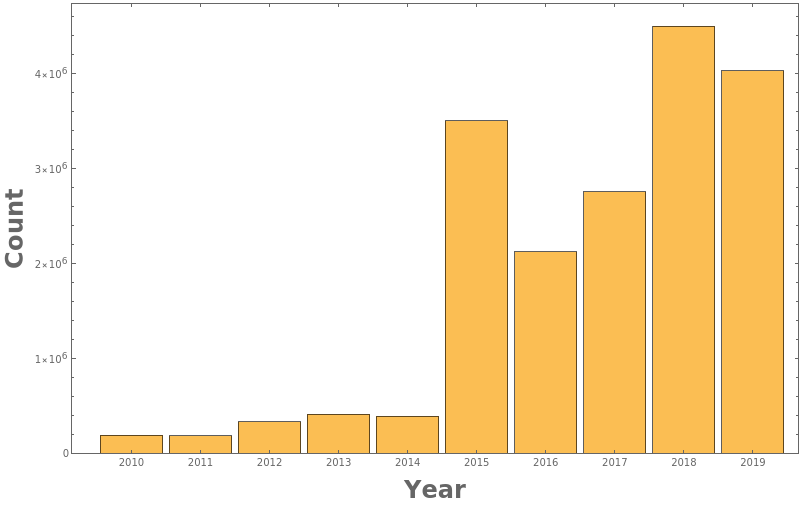

In [90]:
groupedByYear = GroupBy[groupedByCounty[county], #[[13]] &];
medianByYear = KeySort[Median[#[[All, 9]]] & /@ groupedByYear // N]
BarChart[medianByYear, 
    ChartLabels -> Keys[medianByYear], 
    ImageSize->800, 
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Median Price ($)"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]

-Graphics-
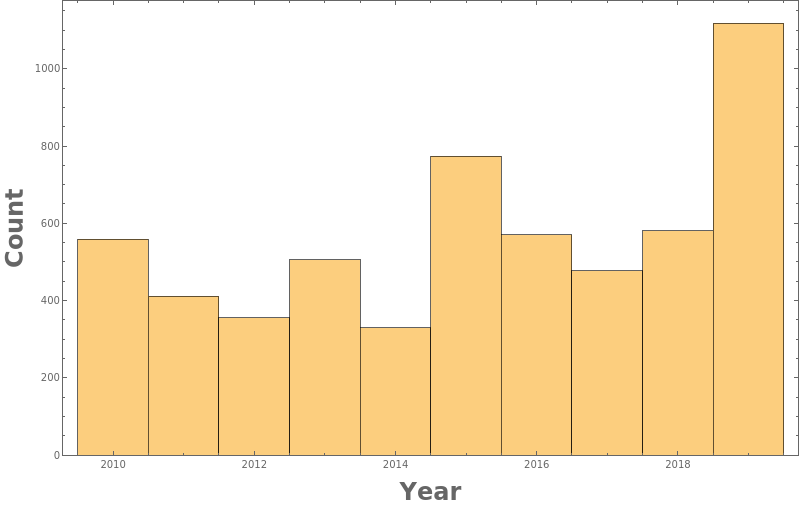

In [97]:
Histogram[groupedByCounty[county][[All, 13]],
    ImageSize->800,
    AxesLabel->(Style[#,Bold,18]&/@{"Year","Count"}),
    Frame->True,FrameLabel -> {Style["Year", Bold, 24], Style["Count", Bold, 24]}]